In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
from pyts.datasets import make_cylinder_bell_funnel

from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans

Using TensorFlow backend.
C:\Users\xhuli\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xhuli\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xhuli\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xhuli\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
data=pd.read_csv("C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/datatraining.txt")
data.index=pd.to_datetime(data.date, format='%Y-%m-%d %H:%M:%S')
data["day_night"]=0
data.loc[(data.index.hour >= 7)&(data.index.hour <= 19), ["day_night"]]=1
data.sort_index(inplace=True)
light=data[["Light", "day_night"]]
temp=data[["Temperature", "day_night"]]
hum=data[["Humidity", "day_night"]]
data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day_night
date,,,,,,,,
2015-02-04 17:51:00,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,1
2015-02-04 17:51:59,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,1
2015-02-04 17:53:00,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,1
2015-02-04 17:54:00,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,1
2015-02-04 17:55:00,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,1


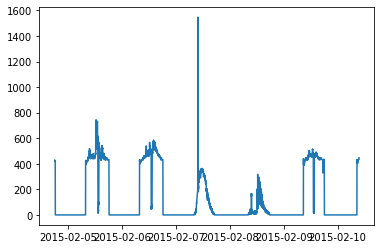

In [3]:
plt.plot(data.Light)
plt.show()

### Create new time series with different temporal splits

In [4]:
# aggregated time series

# light_deci_s=light.resample('100L').bfill()
light_two_m=light.resample('2T').mean()
light_three_m=light.resample('3T').mean()
light_four_m=light.resample('4T').mean()
light_five_m=light.resample('5T').mean()
light_six_m=light.resample('6T').mean()
light_hourly=light.resample('60T').mean()

# temp_deci_s=temp.resample('100L').bfill()
temp_two_m=temp.resample('2T').mean()
temp_three_m=temp.resample('3T').mean()
temp_four_m=temp.resample('4T').mean()
temp_five_m=temp.resample('5T').mean()
temp_six_m=temp.resample('6T').mean()
temp_hourly=temp.resample('60T').mean()

# hum_deci_s=hum.resample('100L').bfill()
hum_two_m=hum.resample('2T').mean()
hum_three_m=hum.resample('3T').mean()
hum_four_m=hum.resample('4T').mean()
hum_five_m=hum.resample('5T').mean()
hum_six_m=hum.resample('6T').mean()
hum_hourly=hum.resample('60T').mean()

# split time series in 60 minutes series with on offset of 20 minutes

ts_light=[]
ts_light_labels=[]
for i in range(0,len(light),20):
    try:
        if len(light.iloc[i:i+60,0].to_list())==60:
            ts_light.append(light.iloc[i:i+60,0].to_list())
            ts_light_labels.append(light.iloc[i:i+60,1].mean())
        else:
            pass
    except:
        pass
ts_light_labels=[1 if x>0.65 else 0 for x in ts_light_labels]

### Example of artificially generated datasets with different classes and their visualizations

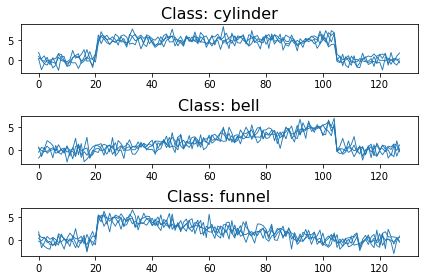

In [5]:
X, y = make_cylinder_bell_funnel(n_samples=12, random_state=42)

plt.figure()
for i, classe in enumerate(['cylinder', 'bell', 'funnel']):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.9)
plt.show()

### Display the splitted series grouped by class

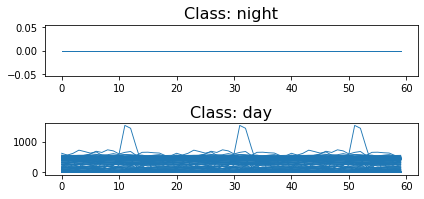

In [6]:
ts_labels=np.array(ts_light_labels)
ts=np.array(ts_light)

plt.figure()
for i, classe in enumerate(['night', 'day']):
    plt.subplot(3, 1, i + 1)
    for x in ts[ts_labels == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.9)
plt.show()

### Shapelet finding

In [7]:
n_ts, ts_sz = ts.shape
n_classes = len(set(ts_labels))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

In [8]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        max_iter=3000,
                        verbose=1, 
                        random_state=42)

In [9]:
shp_clf.fit(ts, ts_labels)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/3000
405/405 [==============================] - 0s 431us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 3/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 4/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 5/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 6/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy

405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 54/3000
405/405 [==============================] - 0s 17us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 55/3000
405/405 [==============================] - 0s 17us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 56/3000
405/405 [==============================] - 0s 17us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 57/3000
405/405 [==============================] - 0s 12us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 58/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 59/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 60/3000
405/405 [====

405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 112/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 113/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 114/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 115/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 116/3000
405/405 [==============================] - 0s 15us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 117/3000
405/405 [==============================] - 0s 12us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 118/3000
405/40

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 169/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 170/3000
405/405 [==============================] - 0s 17us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 171/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 172/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 173/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 174/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 175/3000
405/40

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 226/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 227/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 228/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 229/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 230/3000
405/405 [==============================] - ETA: 0s - loss: 7.6605 - binary_accuracy: 0.5195 - binary_crossentropy: 7.660 - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 231/3000
405/405 [==============================] - 0s 20us/step - loss: 8.07

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 283/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 284/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 285/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 286/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 287/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 288/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 289/3000
405/40

405/405 [==============================] - 0s 24us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 340/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 341/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 342/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 343/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 344/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 345/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 346/3000
405/40

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 397/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 398/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 399/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 400/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 401/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 402/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 403/3000
405/40

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 454/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 455/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 456/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 457/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 458/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 459/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 460/3000
405/40

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 511/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 512/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 513/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 514/3000
405/405 [==============================] - 0s 21us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 515/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 516/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 517/3000
405/40

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 568/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 569/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 570/3000
405/405 [==============================] - 0s 23us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 571/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 572/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 573/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 574/3000
405/40

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 625/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 626/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 627/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 628/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 629/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 630/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 631/3000
405/40

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 682/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 683/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 684/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 685/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 686/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 687/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 688/3000
405/40

405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 739/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 740/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 741/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 742/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 743/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 744/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 745/3000
405/40

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 796/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 797/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 798/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 799/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 800/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 801/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 802/3000
405/40

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 853/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 854/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 855/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 856/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 857/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 858/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 859/3000
405/40

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 910/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 911/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 912/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 913/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 914/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 915/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 916/3000
405/40

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 967/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 968/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 969/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 970/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 971/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 972/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 973/3000
405/40

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1024/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1025/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1026/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1027/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1028/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1029/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1030/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1080/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1081/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1082/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1083/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1084/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1085/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1086/3000

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1136/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1137/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1138/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1139/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1140/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1141/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1142/3000

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1193/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1194/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1195/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1196/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1197/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1198/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1199/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1250/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1251/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1252/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1253/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1254/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1255/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1256/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1307/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1308/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1309/3000
405/405 [==============================] - 0s 23us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1310/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1311/3000
405/405 [==============================] - 0s 23us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1312/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1313/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1364/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1365/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1366/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1367/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1368/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1369/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1370/3000

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1421/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1422/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1423/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1424/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1425/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1426/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1427/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1477/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1478/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1479/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1480/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1481/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1482/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1483/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1533/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1534/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1535/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1536/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1537/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1538/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1539/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1590/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1591/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1592/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1593/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1594/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1595/3000
405/405 [==============================] - 0s 19us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1596/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1647/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1648/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1649/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1650/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1651/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1652/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1653/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1704/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1705/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1706/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1707/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1708/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1709/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1710/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1760/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1761/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1762/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1763/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1764/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1765/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1766/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1817/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1818/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1819/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1820/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1821/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1822/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1823/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1874/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1875/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1876/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1877/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1878/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1879/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1880/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1931/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1932/3000
405/405 [==============================] - ETA: 0s - loss: 7.5360 - binary_accuracy: 0.5273 - binary_crossentropy: 7.536 - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1933/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1934/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1935/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1936/3000
405/405 [==============================] - 0s 22us/step - loss

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1987/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1988/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1989/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1990/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1991/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1992/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1993/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2044/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2045/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2046/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2047/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2048/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2049/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2050/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2101/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2102/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2103/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2104/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2105/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2106/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2107/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2157/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2158/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2159/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2160/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2161/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2162/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2163/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2214/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2215/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2216/3000
405/405 [==============================] - 0s 24us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2217/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2218/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2219/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2220/3000

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2271/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2272/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2273/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2274/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2275/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2276/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2277/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2328/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2329/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2330/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2331/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2332/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2333/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2334/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2385/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2386/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2387/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2388/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2389/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2390/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2391/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2442/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2443/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2444/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2445/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2446/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2447/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2448/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2499/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2500/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2501/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2502/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2503/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2504/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2505/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2556/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2557/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2558/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2559/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2560/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2561/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2562/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2613/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2614/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2615/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2616/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2617/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2618/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2619/3000

405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2669/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2670/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2671/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2672/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2673/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2674/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2675/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2726/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2727/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2728/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2729/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2730/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2731/3000
405/405 [==============================] - 0s 17us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2732/3000

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2783/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2784/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2785/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2786/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2787/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2788/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2789/3000

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2840/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2841/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2842/3000
405/405 [==============================] - 0s 101us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2843/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2844/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2845/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2846/300

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2897/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2898/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2899/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2900/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2901/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2902/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2903/3000

405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2953/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2954/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2955/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2956/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2957/3000
405/405 [==============================] - 0s 20us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2958/3000
405/405 [==============================] - 0s 22us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2959/3000

ShapeletModel(batch_size=256, max_iter=3000, n_shapelets_per_size={6: 4},
              optimizer='sgd', random_state=42, shapelet_length=0.15,
              total_lengths=3, verbose=1, verbose_level=None,
              weight_regularizer=0.0)

In [10]:
predicted_labels = shp_clf.predict(ts)
print("Correct classification rate:", accuracy_score(ts_labels, predicted_labels))

405/405 [==============================] - 0s 131us/step
Correct classification rate: 0.49382716049382713


In [11]:
predicted_locations = shp_clf.locate(ts)

405/405 [==============================] - 0s 133us/step


C:\Users\xhuli\anaconda3\lib\site-packages\tslearn\utils.py:63: UserWarning: 2-Dimensional data passed. Assuming these are 405 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


### Display time series number 43 and its shapelets

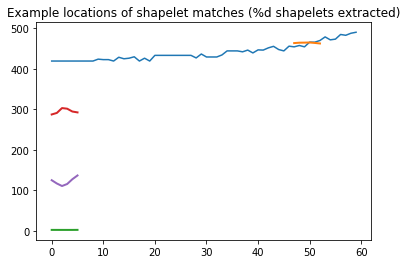

In [12]:
ts_id = 43
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))

plt.plot(ts[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

### Matrix profile 

In [13]:
from matrixprofile import *

In [14]:
w = 60
mp = matrixProfile.stomp(ts.flatten(), w)

C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:118: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\matrixProfile.py:249: RuntimeWarning: invalid value encountered in less
  idsToUpdate = distanceProfile < mp
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: 

### Motifs

In [15]:
mtfs ,motif_d  = motifs.motifs(ts.flatten(), mp, max_motifs=10)

C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:66: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))


# CLUSTERING

### Shape-based Clustering

In [16]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks

In [ ]:
ts

In [17]:
# euclidean

km = TimeSeriesKMeans(n_clusters=2, metric="euclidean", max_iter=5, random_state=0)
km.fit(ts)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=2, n_init=1, n_jobs=None,
                 random_state=0, tol=1e-06, verbose=0)

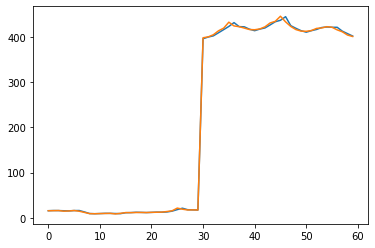

In [18]:
plt.plot(km.cluster_centers_.reshape(ts.shape[1], 2))
plt.show()

In [19]:
print("Correct classification rate:", round(accuracy_score(ts_labels, km.labels_), 3))

Correct classification rate: 0.763


In [20]:
km.inertia_

375891.360224803

In [21]:
# dtw

km_dtw = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(ts)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=2, n_init=1, n_jobs=None, random_state=0, tol=1e-06,
                 verbose=0)

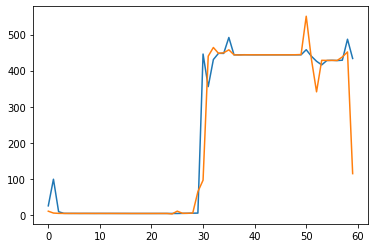

In [22]:
plt.plot(km_dtw.cluster_centers_.reshape(ts.shape[1], 2))
plt.show()

In [23]:
print("Correct classification rate:", round(accuracy_score(ts_labels, km_dtw.labels_), 3))

Correct classification rate: 0.788


In [24]:
km_dtw.inertia_

184890.19081871977

### Features-based Clustering

In [25]:
import scipy.stats as stats

In [26]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [27]:
F = [list(calculate_features(x).values())[:-3] for x in ts]

C:\Users\xhuli\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [28]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [29]:
kmeans.inertia_

7141695737.958196

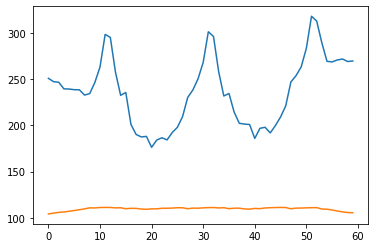

In [30]:
for i in range(2):
    plt.plot(np.mean(ts[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

In [31]:
print("Correct classification rate:", round(accuracy_score(ts_labels, kmeans.labels_), 3))

Correct classification rate: 0.427


### Compression-based Clustering

In [32]:
from sklearn.metrics import pairwise_distances
import zlib
import string

In [33]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [34]:
M = pairwise_distances(ts, metric=cdm_dist)

In [35]:
M.shape

(405, 405)

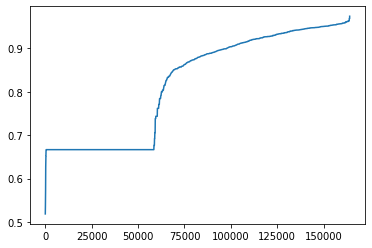

In [36]:
plt.plot(sorted(M.ravel()))
plt.show()

In [37]:
from sklearn.cluster import DBSCAN

In [38]:
dbscan = DBSCAN(eps=0.965, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(algorithm='auto', eps=0.965, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

### Approximated clustering

In [39]:
from tslearn.piecewise import PiecewiseAggregateApproximation

In [40]:
n_paa_segments = 2
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(ts)

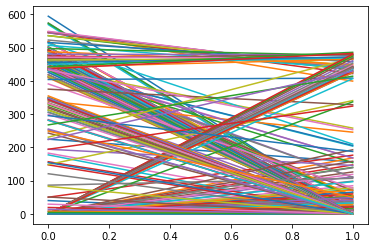

In [41]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [42]:
km = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0)
km.fit(X_paa)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=2, n_init=1, n_jobs=None, random_state=0, tol=1e-06,
                 verbose=0)

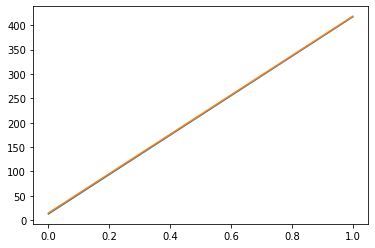

In [43]:
plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 2))
plt.show()

In [44]:
print("Correct classification rate:", round(accuracy_score(ts_labels, km.labels_), 3))

Correct classification rate: 0.763


# FORECASTING

In [45]:
ts=light_hourly.Light

### Log Tranformation

C:\Users\xhuli\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


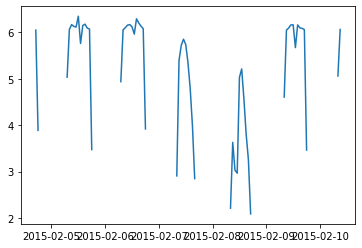

In [46]:
ts_log = pd.Series(np.log(ts), index=ts.index)
plt.plot(ts_log)
plt.show()

### Diff Tranformation

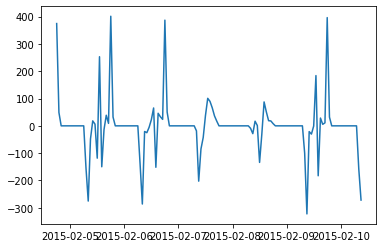

In [47]:
ts_diff = pd.Series(ts[:-1].values - ts[1:].values, index=ts.index[1:])
plt.plot(ts_diff)
plt.show()

### Log Mean Diff Tranformation

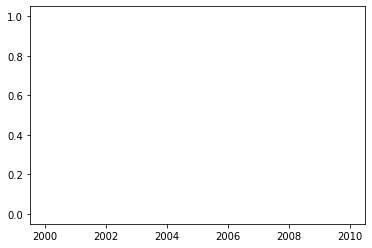

In [48]:
window = 60
ts_log_mov_diff = pd.Series(ts_log - ts_log.rolling(window, center=False).mean(), index=ts.index)
plt.plot(ts_log_mov_diff)
plt.show()

### Autocorrelation and Partial Autocorrelation

In [49]:
from statsmodels.tsa.stattools import acf, pacf

In [50]:
lag_acf = acf(light_hourly.Light, nlags=120)
lag_pacf = pacf(light_hourly.Light, nlags=120, method='ols')

C:\Users\xhuli\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [51]:
# i=0
# for x in [round(x,2) for x in lag_pacf]:
#     print(i,x)
#     i+=1

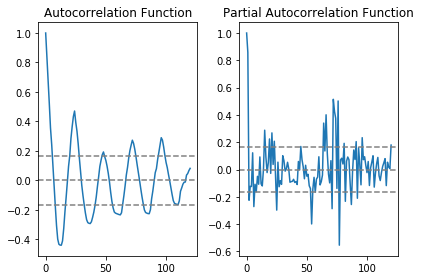

In [52]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

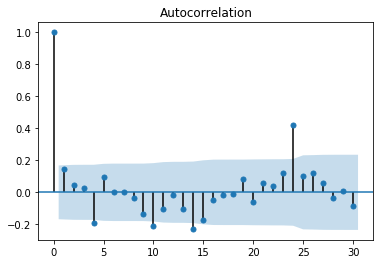

In [54]:
plot_acf(ts_diff.values[:], lags=30)
plt.show()

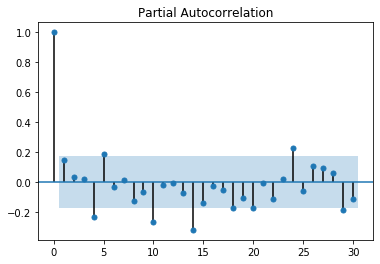

In [55]:
plot_pacf(ts_diff.values[11:], lags=30)
plt.show()

### Stationarity 
The Augmented Dickey-Fuller unit root test (http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).
Estimates whether the time series has a time-dependent structure (non-stationary, i.e. affected by trend, seasonality and other phenomena that make the statistics of the time series to vary in time) or not (stationary), which are related to (though quite different from) periodicity and autocorrelation.

In [56]:
from statsmodels.tsa.stattools import adfuller

In [57]:
dftest = adfuller(ts, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -4.750303
p-value                          0.000068
#Lags Used                       7.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


### Decomposition

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

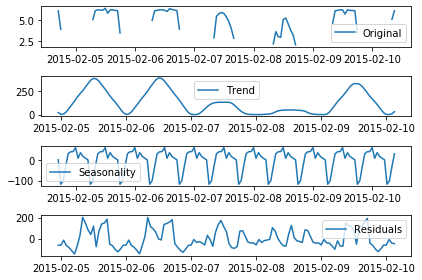

In [59]:
decomposition = seasonal_decompose(ts, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Forecasting

In [60]:
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [61]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error


def r2_score(y_true, y_pred, ts):
    mu = np.mean(ts)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred, ts),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred)
    }

In [62]:
split_index = 109
train, test = ts.iloc[:109], ts.iloc[109:]

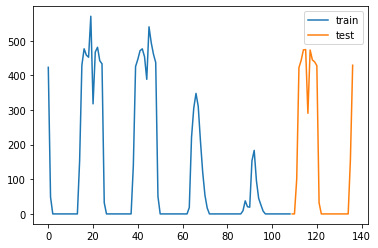

In [63]:
plt.plot(range(split_index), train, label='train')
plt.plot(range(split_index, len(ts)), test, label='test')
plt.legend()
plt.show()

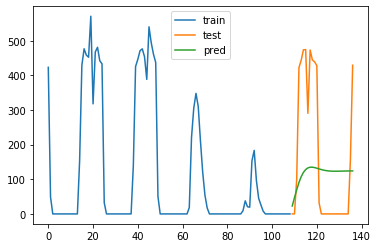

MAE 176.041
RMSE 206.436
MAD 124.151
R2 -inf
MAPE 1.496
MAXAPE 3.659
TAPE 41.884


C:\Users\xhuli\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [64]:
arima = ARIMA(train, order=(4,0,0)).fit()
pred = arima.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

C:\Users\xhuli\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\xhuli\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


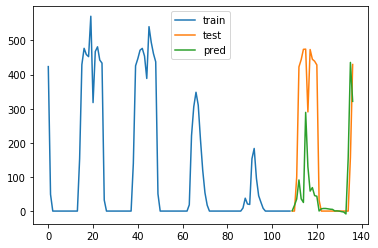

MAE 136.064
RMSE 213.179
MAD 24.181
R2 0.340
MAPE 6.750
MAXAPE 106.409
TAPE 189.010


In [65]:
sarimax = SARIMAX(train, order=(1,0,0), seasonal_order=(12, 1, 0, 12)).fit(disp=False)
pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_diff).items():
    print('%s %.3f' % (k, v))

In [ ]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2, 4, 10, 14, 24]
    d_params = [0, 1]
    q_params = [0, 1, 2, 4, 10, 14, 24]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2, 4, 10, 14, 24]
    D_params = [0, 1]
    Q_params = [0, 1, 2, 4, 10, 14, 24]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

if __name__ == '__main__':
    # define dataset
    data = ts
    print(data)
    # data split
    n_test = 20
    # model configs
    cfg_list = sarima_configs()
    # grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

date
2015-02-04 17:00:00    423.277778
2015-02-04 18:00:00     48.875000
2015-02-04 19:00:00      0.000000
2015-02-04 20:00:00      0.000000
2015-02-04 21:00:00      0.000000
                          ...    
2015-02-10 05:00:00      0.000000
2015-02-10 06:00:00      0.000000
2015-02-10 07:00:00      0.000000
2015-02-10 08:00:00    157.672316
2015-02-10 09:00:00    429.397059
Freq: 60T, Name: Light, Length: 137, dtype: float64
